# Expression Level of DEGs in 24h dNipBL mESCs and proximity to ChIP features

***Purpose:*** Plotting distance from promoter of DEGs to ChIP signal to see relationship between proximity of the chromatin-interacting proteins and differential expression.

* Cumulative portion of genes relative to TSS
* Concentration of CTCF peaks within a TAD compared to DEGs

In [1]:
import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load data and project files

- dNipbL dataset 
- ChIP .bed files

In [3]:
day1_res_df = flt.load_tss_df()
# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [4]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf = "CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed"
rad21 = "RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed"
nipbl = "Nipbl_112.175.197.114.177.196_peaks.xls.bed"
promoter = "H3K27ac_EA92-97_peaks.xls.bed"

chip_peaks_condition_dict = {'CTCF' : chip_folder+ctcf, 'RAD21' : chip_folder+rad21,
                           'NIPBL' : chip_folder+nipbl, 'H3K27ac' : chip_folder+promoter}

# Concentration of CTCF within TADs of DEG

In [7]:
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

In [8]:
# Break up the categories into quantiles according ot vst_counts
quantiled_df = day1_res_df.copy()

quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts")
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts", label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts", label_subset='down')

In [10]:
category_colormap_big = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',

                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

category_colormap_degs = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',
                        }

In [77]:
def distribution_regions_by_features(
    region_df,
    feature_df,
    region_group_col='num_enhancers',
    feature_agg_key='DE_status',
    feature_name='TADs',
    feature_category_colors={"up": 'tab:red', 
                             "down": 'tab:blue',
                             "nonsig": 'tab:grey'},
    bin_size=1,
    percentage=True,
    ax=None,
    num_genes_cutoff=1,
    plot_title=None
):
    """
    Plots bar graph of regions containing one or more of some
    aggregated category. e.g. TADs with number of features on 
    x-axis, count of TADs split by DE_status on y-axis
    
    Parameters:
    -----------
    region_df: bioframe df with one interval (chr, start, end) for regions.
    feature_df: bioframe df with one interval (chr, start, end) for features (e.g. genes)
    region_group_col: column in region_df with categories of the regions.
    feature_agg_key: column in feature_df that has category labels for aggregation.
    feature_category_colors: categories in feature_df[feature_agg_key] and colors for plotting.
    bin_size: for grouping region_group_col into bins
    percentage: True/False whether to take percentage of total TADs
    ax: axis for plotting
    num_genes_cutoff: selecting a cutoff value for counting in feature_agg_key
    plot_title: title
    
    Returns:
    --------
    bar plot
    """
    
    if ax == None:
        ax = plt.subplot()

    groups = pd.DataFrame()
    bar_size = 1/(len(feature_category_colors) + 1)
    x_pos = 0
    max_count_val = max(region_df[region_group_col])


    # collect the number of overlapping features per region for each category
    for cat, _ in feature_category_colors.items():

        cat_ix = np.where(feature_df[feature_agg_key] == cat)

        if feature_df.iloc[cat_ix].shape[0] < 1:
            warnings.warn(
                (
                "category {} is empty, skipped in plotting".
                    format(cat)
                )
            )
            continue

        region_df[cat+'_counts'] = bf.count_overlaps(region_df, feature_df.iloc[cat_ix])['count']

    # create x-axis values, where each bin is [a, b)
    bins = np.arange(0, max_count_val+1, bin_size)

    # aggregate across bins to generate bar plot
    for cat, color in feature_category_colors.items():

        counts = []
        for i in bins:

            counts.append(region_df.iloc[
                            np.where(region_df[cat+'_counts'] >= num_genes_cutoff)
                            ].groupby(region_group_col).count()[cat+'_counts'][i:i+bin_size].sum())

        groups[cat] = counts
        
        if percentage:
            vals = groups[cat]/groups[cat].sum()
            lab = 'Percentage of {} containing \n >= {} gene with {}'.format(feature_name,
                                                                   num_genes_cutoff,
                                            ' '.join(feature_agg_key.split('_')))
        else:
            vals = counts
            lab = 'Number of {} containing \n >= {} gene with {}'.format(feature_name,
                                                                   num_genes_cutoff,
                                            ' '.join(feature_agg_key.split('_')))
            
        ax.bar(groups.index + x_pos + .75*bar_size, vals, width=bar_size, color=color, label=cat)
        x_pos += bar_size

    ax.set(
    xticks=groups.index,
    xticklabels=bins,
    xlabel=' '.join(region_group_col.split('_')),
    ylabel='Percentage of {} containing \n >= {} gene with {}'.format(feature_name,
                                                                   num_genes_cutoff,
                                            ' '.join(feature_agg_key.split('_')))
    )
    ax.legend()

    if plot_title != None:
        ax.set_title(plot_title)

In [87]:
import importlib
importlib.reload(pfn)

<module 'plotting_histogram_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py'>

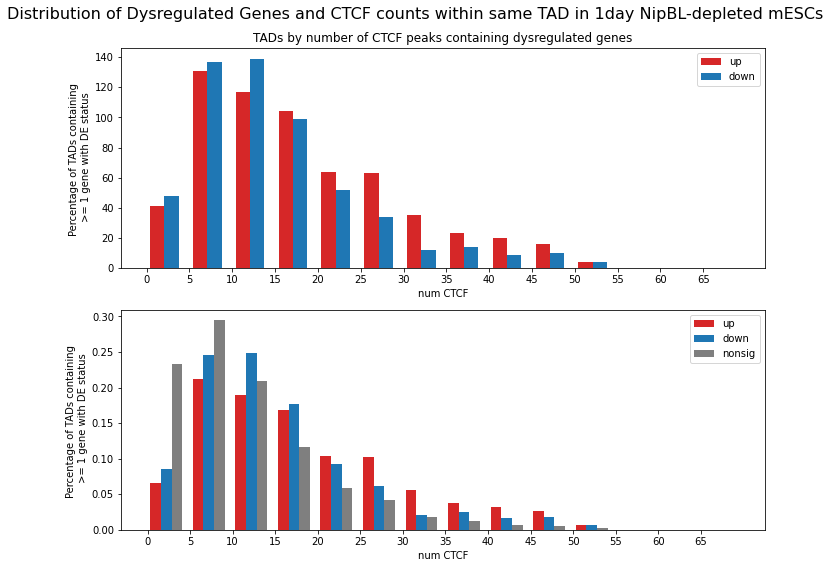

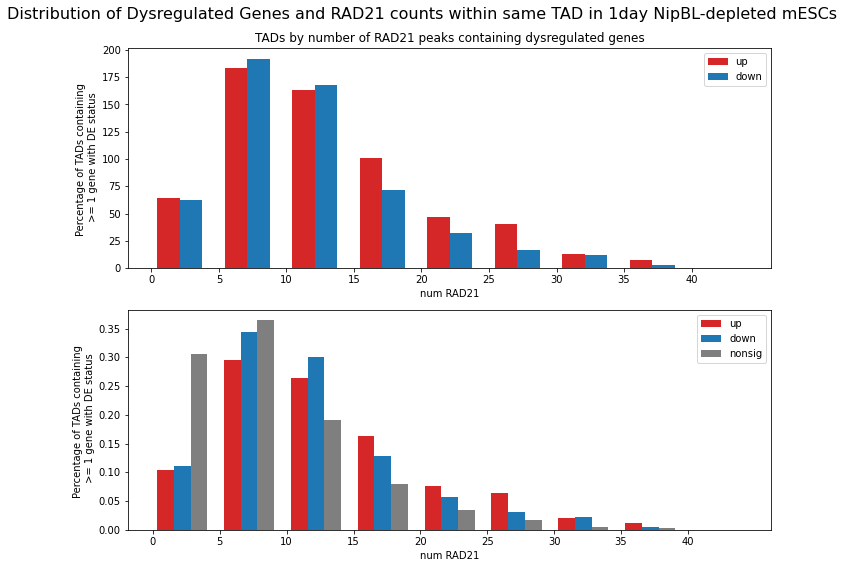

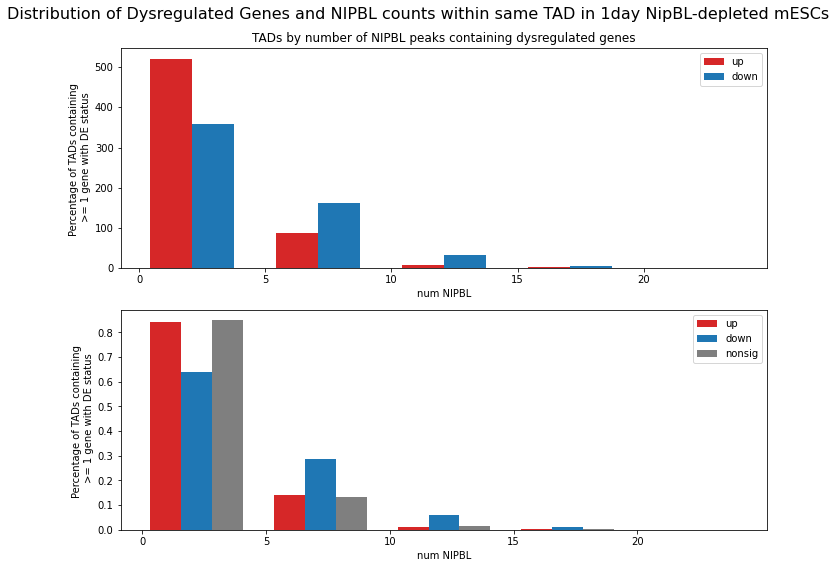

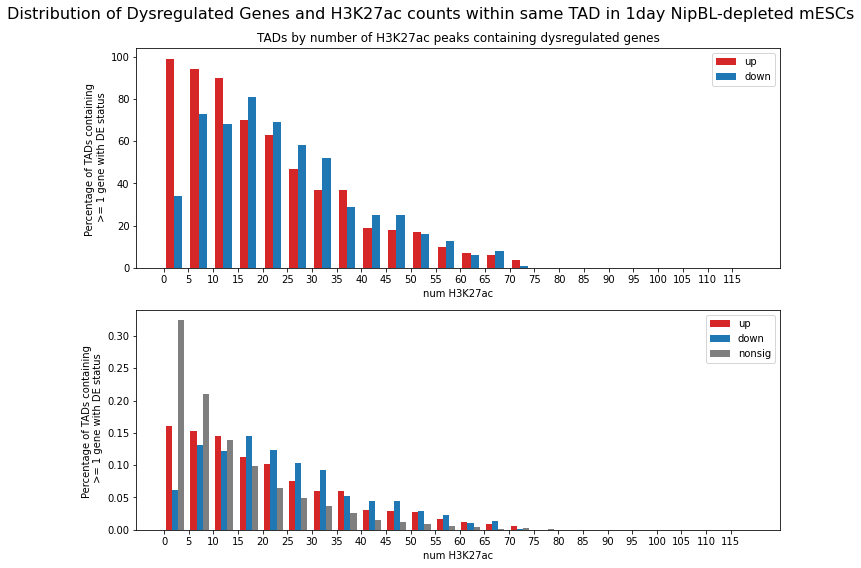

In [88]:
genes_cutoff=1
bin_size=5
for (feat, file) in chip_peaks_condition_dict.items():

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(('Distribution of Dysregulated Genes and '
                '{} counts within same TAD in 1day NipBL-depleted mESCs'.
                format(feat)),
                fontsize=16)

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    chip_df = flt.get_peak_bioframe(file)
    df['num_'+feat] = bf.count_overlaps(df, chip_df)['count']
    
    pfn.distribution_regions_by_features(df,
                                day1_res_df,
                                region_group_col='num_'+feat,
                                plot_title='TADs by number of {} peaks containing dysregulated genes'.format(feat),
                                feature_category_colors={"up": 'tab:red', 
                                                    "down": 'tab:blue'},
                                percentage=False,
                                num_genes_cutoff=genes_cutoff,
                                bin_size=bin_size,
                                ax=axs[0]
                                )
                                
    pfn.distribution_regions_by_features(df,
                                day1_res_df,
                                region_group_col='num_'+feat,
                                percentage=True,
                                num_genes_cutoff=genes_cutoff,
                                bin_size=bin_size,
                                ax=axs[1]
                                )
    
    plt.tight_layout()
    plt.show()

In [57]:
bin_size=2
region_df.iloc[np.where(region_df['nonsig_counts'] > 0)].groupby(region_group_col).count()['nonsig_counts'][0:2].sum()


208

In [39]:
region_df.groupby(region_group_col)['nonsig_counts'].sum()

count_ctcf_peaks
0     104
1     231
2     360
3     476
4     541
5     587
6     621
7     780
8     693
9     716
10    625
11    821
12    860
13    689
14    725
15    569
16    665
17    590
18    492
19    456
20    467
21    313
22    447
23    416
24    199
25    316
26    427
27    243
28    252
29    311
30    236
31    150
32    111
33    208
34    144
35    154
36    168
37    176
38     98
39    164
40    112
41     77
42     47
43    153
44    116
45     80
47    156
48     18
49     64
50     67
53    109
56     21
59     25
60     50
61     71
65     24
Name: nonsig_counts, dtype: int64

In [29]:
region_df.groupby(region_group_col).count()

,chrom,start,end,up_counts,down_counts,nonsig_counts
count_ctcf_peaks,,,,,,
0,221,221,221,221,221,221
1,322,322,322,322,322,322
2,353,353,353,353,353,353
3,354,354,354,354,354,354
4,331,331,331,331,331,331
5,317,317,317,317,317,317
6,287,287,287,287,287,287
7,269,269,269,269,269,269
8,227,227,227,227,227,227


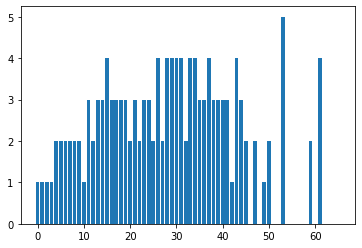

In [25]:
ax = plt.subplot()
ax.bar(region_df['count_ctcf_peaks'], region_df['up_counts'])
plt.show()

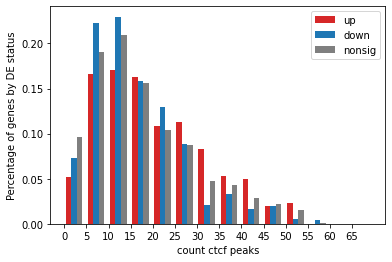

In [58]:
df = tad_mid_df.copy()
ctcf_df = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])
df['count_ctcf_peaks'] = bf.count_overlaps(df, ctcf_df)['count']

pfn.distribution_features_by_region(df, 
                                    day1_res_df,
                                    region_group_col='count_ctcf_peaks',
                                    bin_size=5)

In [15]:
# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# Annotate number of CTCF within the tad
df = tad_mid_df.copy()
ctcf_df = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])
df['count_ctcf_peaks'] = bf.count_overlaps(df, ctcf_df)['count']

In [16]:
# # Assign bins for ctcf counts to group them
# df = pfn.assign_bin(df, 'count_ctcf_peaks', np.arange(0, 70, 5), 'count_ctcf_bin')

In [17]:
# Add column to gene df with the count of ctcfs
day1_res_df['count_ctcf_within_tad'] = bf.overlap(day1_res_df, df, how='inner', suffixes=('_genes', '_tads'))['count_ctcf_peaks_tads']

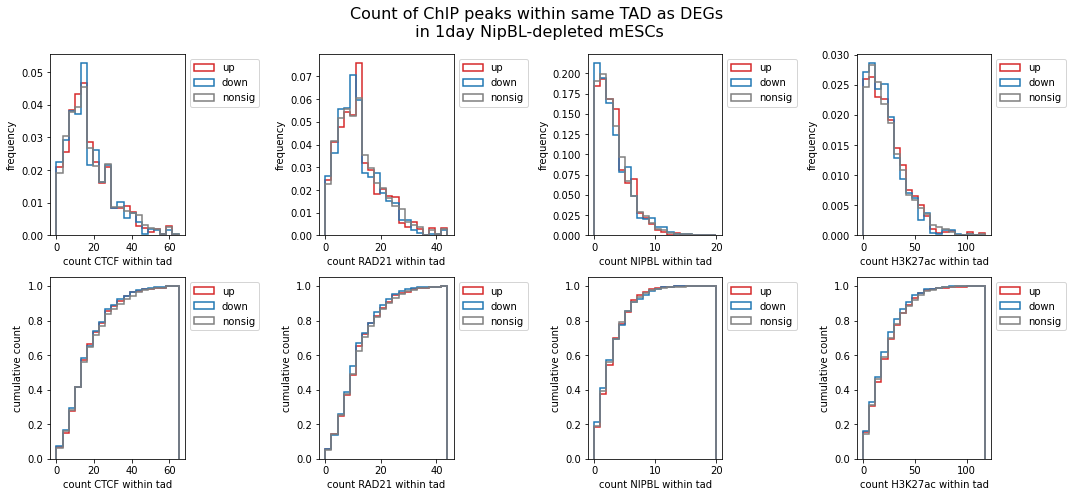

In [21]:
fig, axs = plt.subplots(2, len(chip_peaks_condition_dict), figsize=(15, 7))

i = 0
for chip, file in chip_peaks_condition_dict.items():
    ctcf_df = flt.get_peak_bioframe(file)
    df['count_'+chip+'_peaks'] = bf.count_overlaps(df, ctcf_df)['count']
    day1_res_df['count_'+chip+'_within_tad'] = bf.overlap(day1_res_df, df, how='inner', suffixes=('_genes', '_tads'))['count_'+chip+'_peaks_tads']

    fig.suptitle(('Count of ChIP peaks within same TAD as DEGs'
                 '\n in 1day NipBL-depleted mESCs'),
                 fontsize=16)

    pfn.plot_count_histogram(day1_res_df,
                         'count_'+chip+'_within_tad',
                        cumulative=True,
                         bins=20,
                        ax=axs[1, i])

    pfn.plot_count_histogram(day1_res_df,
                         'count_'+chip+'_within_tad',
                        cumulative=False,
                        bins=20,
                        ax=axs[0, i])
    i+=1


plt.tight_layout()
plt.show()

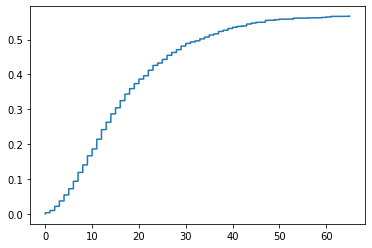

In [32]:
plt.plot(day1_res_df.sort_values(['count_ctcf_within_tad'])['count_ctcf_within_tad'].values, np.linspace(0, 1, len(day1_res_df)))



In [20]:
day1_res_df['DE_status'].value_counts()

nonsig    17791
up          831
down        727
Name: DE_status, dtype: int64

In [21]:
quantiled_df['DE_status'].value_counts()

nonsig_0.0-0.5      9180
nonsig_0.5-0.75     4281
nonsig_0.75-0.95    3476
nonsig_0.95-1.0      854
up_0.0-0.5           363
up_0.5-0.75          342
down_0.75-0.95       283
down_0.5-0.75        214
down_0.0-0.5         132
up_0.75-0.95         110
down_0.95-1.0         98
up_0.95-1.0           16
Name: DE_status, dtype: int64

In [22]:
quantiled_df[['status', 'quantile']] = quantiled_df['DE_status'].str.split('_', expand=True)

array([[<AxesSubplot:title={'center':'down'}>,
        <AxesSubplot:title={'center':'nonsig'}>],
       [<AxesSubplot:title={'center':'up'}>, <AxesSubplot:>]],
      dtype=object)

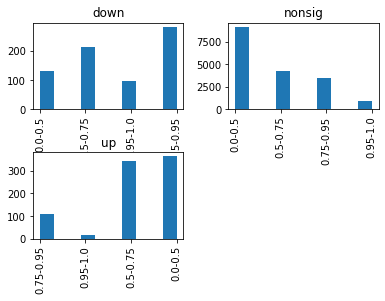

In [23]:
quantiled_df['quantile'].hist(by=quantiled_df['status'])